## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)

import matplotlib.patches as patches

/Users/rok/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import spark_fof
reload(spark_fof)
from spark_fof import Particle, groupID, get_bin, set_local_group

In [3]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))
    
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)

## Set up data

In [4]:
data = []
data.append(Particle(-.35,-.35,0,groupID(1,1)))
data.append(Particle(-.27,-.27,1,groupID(1,1)))
data.append(Particle(-.23,-.23,2,groupID(1,1)))
data.append(Particle(-.19,-.19,3,groupID(1,1)))
data.append(Particle(-.01,-.01,4,groupID(1,1)))
data.append(Particle(0.01,0.01,5,groupID(1,1)))
data.append(Particle(0.23,0.23,6,groupID(1,1)))
data.append(Particle(0.29,0.29,7,groupID(1,1)))
data.append(Particle(0.49,0.49,8,groupID(1,1)))
data.append(Particle(0.51,0.51,9,groupID(1,1)))

In [5]:
data_array = np.zeros(len(data), dtype = spark_fof.pdt)
for i,p in enumerate(data): 
    data_array[i]['x'] = p.x
    data_array[i]['y'] = p.y
    data_array[i]['pid'] = p.pid

## Start Spark

In [6]:
import findspark
findspark.init()

In [7]:
import pyspark
from pyspark import SparkContext, SparkConf

In [8]:
conf = SparkConf()

In [9]:
import os

In [10]:
os.environ['SPARK_DRIVER_MEMORY']= '4G'

In [11]:
conf.set('spark.python.profile', 'true')
conf.set('spark.executor.memory', '5G')
conf.set('spark.driver.memory', '4G')


In [12]:
sc = SparkContext(master='local[4]', conf=conf, batchSize=0)

In [13]:
sc.addPyFile('spark_fof.py')

## Set up the domains

In [14]:
N = 3
tau = 0.05
mins = [-1,-1]
maxes= [1,1]
domain_containers = spark_fof.setup_domain(N,tau)

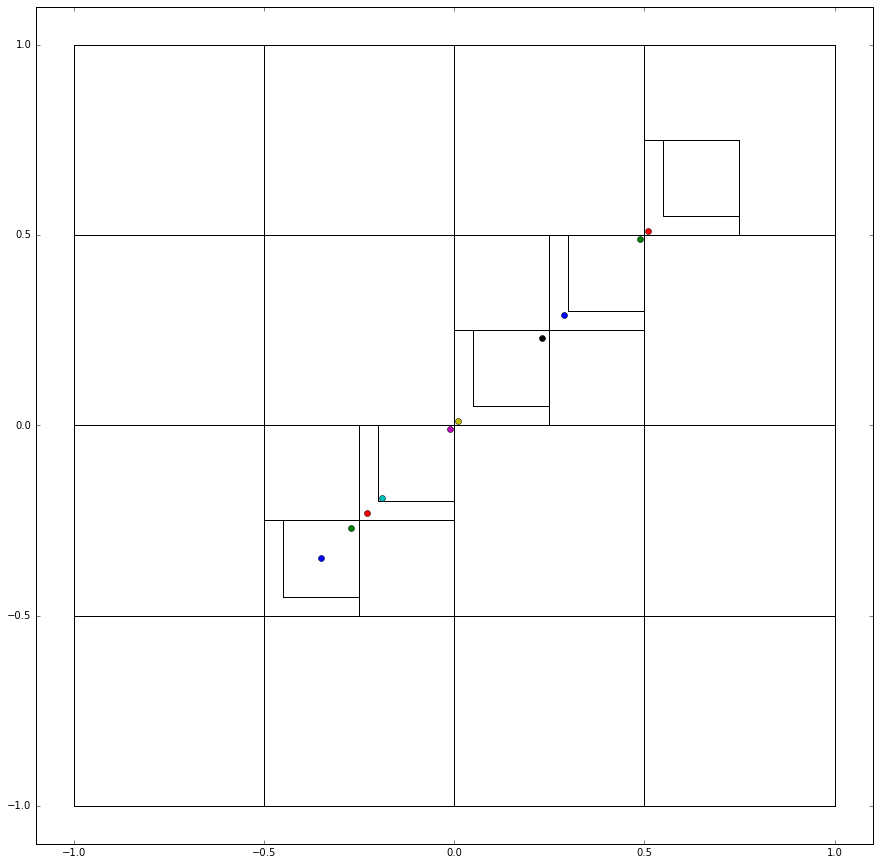

In [15]:
f, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(15,15))
#plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)
for p in data: 
    plot_rectangle(domain_containers[get_bin(p.x, p.y, 2**N, mins,maxes)], ax=ax)
    plot_rectangle(domain_containers[get_bin(p.x, p.y, 2**N, mins,maxes)].bufferRectangle, ax=ax)
    ax.plot(p.x, p.y, 'o')
for r in domain_containers: 
    plot_rectangle(r.parent, ax=ax)

### Make the base RDD

In [16]:
p_rdd = sc.parallelize(data_array)

In [17]:
p_rdd.collect()

[(-0.3499999940395355, -0.3499999940395355, 0, 0),
 (-0.27000001072883606, -0.27000001072883606, 1, 0),
 (-0.23000000417232513, -0.23000000417232513, 2, 0),
 (-0.1899999976158142, -0.1899999976158142, 3, 0),
 (-0.009999999776482582, -0.009999999776482582, 4, 0),
 (0.009999999776482582, 0.009999999776482582, 5, 0),
 (0.23000000417232513, 0.23000000417232513, 6, 0),
 (0.28999999165534973, 0.28999999165534973, 7, 0),
 (0.49000000953674316, 0.49000000953674316, 8, 0),
 (0.5099999904632568, 0.5099999904632568, 9, 0)]

### Partition particles into domains and set the partition part of local group ID

In [18]:
# partitioning duplicates the particles that are located in the boundary regions
part_rdd = (p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles(particles, domain_containers, tau))
                 .partitionBy(len(domain_containers))
                 .values()
                 .mapPartitionsWithIndex(set_local_group))

#### Check the partitioned RDD -- some of the particles will be duplicated

In [19]:
parts = part_rdd.collect()

In [20]:
for i,p in enumerate(parts): 
    print i, p

0 (-0.3499999940395355, -0.3499999940395355, 0, 77309411328)
1 (-0.27000001072883606, -0.27000001072883606, 1, 77309411328)
2 (-0.23000000417232513, -0.23000000417232513, 2, 77309411328)
3 (-0.23000000417232513, -0.23000000417232513, 2, 81604378624)
4 (-0.23000000417232513, -0.23000000417232513, 2, 111669149696)
5 (-0.23000000417232513, -0.23000000417232513, 2, 115964116992)
6 (-0.1899999976158142, -0.1899999976158142, 3, 115964116992)
7 (-0.009999999776482582, -0.009999999776482582, 4, 115964116992)
8 (0.009999999776482582, 0.009999999776482582, 5, 115964116992)
9 (0.009999999776482582, 0.009999999776482582, 5, 120259084288)
10 (0.009999999776482582, 0.009999999776482582, 5, 150323855360)
11 (0.009999999776482582, 0.009999999776482582, 5, 154618822656)
12 (0.23000000417232513, 0.23000000417232513, 6, 154618822656)
13 (0.28999999165534973, 0.28999999165534973, 7, 154618822656)
14 (0.28999999165534973, 0.28999999165534973, 7, 158913789952)
15 (0.28999999165534973, 0.28999999165534973, 7

### Group Merging stage

#### Ugly hack to create a 'fake' data set to look like what we would get out of a first FOF pass

In [21]:
data_partitions = []
for p in parts: 
    data_partitions.append(spark_fof.decode_gid(p['gid'])[0])

In [22]:
fof_rdd = sc.parallelize(zip(data_partitions, parts)).partitionBy(len(domain_containers)).values()

In [23]:
fof_rdd.collect()

[(-0.3499999940395355, -0.3499999940395355, 0, 77309411328),
 (-0.27000001072883606, -0.27000001072883606, 1, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 2, 81604378624),
 (-0.23000000417232513, -0.23000000417232513, 2, 111669149696),
 (-0.23000000417232513, -0.23000000417232513, 2, 115964116992),
 (-0.1899999976158142, -0.1899999976158142, 3, 115964116992),
 (-0.009999999776482582, -0.009999999776482582, 4, 115964116992),
 (0.009999999776482582, 0.009999999776482582, 5, 115964116992),
 (0.009999999776482582, 0.009999999776482582, 5, 120259084288),
 (0.009999999776482582, 0.009999999776482582, 5, 150323855360),
 (0.009999999776482582, 0.009999999776482582, 5, 154618822656),
 (0.23000000417232513, 0.23000000417232513, 6, 154618822656),
 (0.28999999165534973, 0.28999999165534973, 7, 154618822656),
 (0.28999999165534973, 0.28999999165534973, 7, 158913789952),
 (0.28999999165534973, 0.28999999165534973, 7, 18897

In [24]:
mappings_list = []

In [37]:
fof_analyzer = spark_fof.FOFAnalyzer(sc, N, tau, fof_rdd)

In [38]:
merged_rdd = fof_analyzer.merge_groups(0)

In [39]:
merged_rdd.collect()

[(-0.3499999940395355, -0.3499999940395355, 0, 77309411328),
 (-0.27000001072883606, -0.27000001072883606, 1, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
 (-0.1899999976158142, -0.1899999976158142, 3, 77309411328),
 (-0.009999999776482582, -0.009999999776482582, 4, 77309411328),
 (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
 (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
 (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
 (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
 (0.23000000417232513, 0.23000000417232513, 6, 77309411328),
 (0.28999999165534973, 0.28999999165534973, 7, 77309411328),
 (0.28999999165534973, 0.28999999165534973, 7, 77309411328),
 (0.28999999165534973, 0.28999999165534973, 7, 77309411328),
 (

In [40]:
sc.show_profiles()

Profile of RDD<id=26>
         2077 function calls (2013 primitive calls) in 0.007 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       44    0.001    0.000    0.002    0.000 kdtree.py:119(min_distance_point)
       64    0.001    0.000    0.005    0.000 serializers.py:259(dump_stream)
       13    0.000    0.000    0.000    0.000 {cPickle.loads}
       44    0.000    0.000    0.001    0.000 kdtree.py:15(minkowski_distance_p)
       68    0.000    0.000    0.005    0.000 spark_fof.py:258(get_buffer_particles)
       77    0.000    0.000    0.002    0.000 serializers.py:136(load_stream)
       77    0.000    0.000    0.001    0.000 serializers.py:542(read_int)
       44    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       64    0.000    0.000    0.000    0.000 serializers.py:217(load_stream)
       77    0.000    0.000    0.001    0.000 serializers.py:155(_read_with_length)

In [30]:
p_arr = np.array(fof_analyzer.particle_rdd.collect())

In [31]:
groups = np.unique(p_arr['gid'])

In [32]:
for g in groups:
    inds = np.where(p_arr['gid'] == g)
    if g in m.keys():
        p_arr['gid'][inds] = m[g]

In [33]:
p_arr

array([(-0.3499999940395355, -0.3499999940395355, 0, 77309411328),
       (-0.27000001072883606, -0.27000001072883606, 1, 77309411328),
       (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
       (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
       (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
       (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
       (-0.1899999976158142, -0.1899999976158142, 3, 77309411328),
       (-0.009999999776482582, -0.009999999776482582, 4, 77309411328),
       (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
       (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
       (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
       (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
       (0.23000000417232513, 0.23000000417232513, 6, 77309411328),
       (0.28999999165534973, 0.28999999165534973, 7, 77309411328),
       (0.28999999165534973, 0.289999991

In [41]:
def remap_gid_partition(particles, gid_map):
    p_arr = np.fromiter(particles, spark_fof.pdt)
    groups = np.unique(p_arr['gid'])
    for g in groups:
        inds = np.where(p_arr['gid'] == g)
        if g in gid_map.keys():
            p_arr['gid'][inds] = gid_map[g]
    return p_arr

In [42]:
ps = fof_analyzer.particle_rdd.collect()

In [28]:
fof_analyzer.particle_rdd.collect()

[(-0.3499999940395355, -0.3499999940395355, 0, 77309411328),
 (-0.27000001072883606, -0.27000001072883606, 0, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 0, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 0, 81604378624),
 (-0.23000000417232513, -0.23000000417232513, 0, 111669149696),
 (-0.23000000417232513, -0.23000000417232513, 0, 115964116992),
 (-0.1899999976158142, -0.1899999976158142, 0, 115964116992),
 (-0.009999999776482582, -0.009999999776482582, 0, 115964116992),
 (0.009999999776482582, 0.009999999776482582, 0, 115964116992),
 (0.009999999776482582, 0.009999999776482582, 0, 120259084288),
 (0.009999999776482582, 0.009999999776482582, 0, 150323855360),
 (0.009999999776482582, 0.009999999776482582, 0, 154618822656),
 (0.23000000417232513, 0.23000000417232513, 0, 154618822656),
 (0.28999999165534973, 0.28999999165534973, 0, 154618822656),
 (0.28999999165534973, 0.28999999165534973, 0, 158913789952),
 (0.28999999165534973, 0.28999999165534973, 0, 18897

## try get_bin with cython

In [29]:
import numpy as np
# import pyximport
# pyximport.install(setup_args={"include_dirs":np.get_include()},
#                   reload_support=True)

In [30]:
xs = np.random.rand(1000000)
ys = np.random.rand(1000000)

### Setup cython on workers

looks like some helpful info here: https://www.4info.com/Blog/October-2014/Enhancing-Spark-with-IPython-Notebook-and-Cython

In [31]:
sc.addPyFile('spark_fof_c.pyx')
sc.addPyFile('spark_util.py')

In [32]:
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()})   

(None, <pyximport.pyximport.PyxImporter at 0x1187f4a50>)

In [33]:
from spark_util import spark_cython

In [34]:
def get_particle_bin(p):
    from spark_util import spark_cython
    return spark_cython('spark_fof_c', 'get_bin_cython')(p.x,p.y,100,-1,-1,1,1)

def get_particle_bin_numpy(p):
    from spark_util import spark_cython
    return spark_cython('spark_fof_c', 'get_bin_cython')(p['x'],p['y'],100,-1,-1,1,1)

def get_particle_bin_partition(particles, n):
    xs = np.zeros(n)
    ys = np.zeros(n)
    bins = np.zeros(n, dtype=np.int32)
    
    for i, p in enumerate(particles): 
        xs[i]=p.x
        xs[i]=p.y
    
    spark_cython('spark_fof_c', 'get_particle_bins_cython')(xs,ys,bins)
    
    for bin in bins: yield bin

def get_particle_bin_partition_numpy(particles): 
    p_arr = np.fromiter(particles, pdt)
    bins = np.zeros(len(p_arr), dtype=np.int)
    spark_cython('spark_fof_c', 'get_particle_bins_cython')(p_arr['x'], p_arr['y'], bins)
    return bins

def get_particle_bin_python(p):
    return get_bin(p['x'],p['y'],100,[-1,-1],[1,1])

In [35]:
from spark_fof import Particle, groupID

In [36]:
p_arr = []

for i, (x,y) in enumerate(zip(np.random.rand(1000000), np.random.rand(1000000))):
    p_arr.append(Particle(x,y,i,groupID(0,0)))

In [37]:
pdt = np.dtype([('x','f8'), ('y','f8')], )

p_np_arr = np.zeros(1000000,dtype=pdt)

for i in range(len(p_np_arr)):
    p_np_arr[i] = np.random.rand(2)

In [38]:
p_arr_rdd = sc.parallelize(p_arr).cache()
p_np_arr_rdd = sc.parallelize(p_np_arr).cache()

In [39]:
p_arr_rdd.count()

1000000

In [40]:
p_np_arr_rdd.count()

1000000

In [49]:
%time p_arr_rdd.map(get_particle_bin).count()

CPU times: user 6.1 ms, sys: 1.85 ms, total: 7.95 ms
Wall time: 2.73 s


1000000

In [50]:
sc.show_profiles()

Profile of RDD<id=29>
         5009057 function calls (5009049 primitive calls) in 10.122 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      977    6.595    0.007    6.595    0.007 {cPickle.loads}
  1000000    1.913    0.000    2.603    0.000 <ipython-input-34-70e5b75fae3f>:1(get_particle_bin)
  1000004    0.722    0.000    9.981    0.000 rdd.py:1004(<genexpr>)
  1000000    0.285    0.000    0.486    0.000 spark_util.py:4(wrapped)
  1000000    0.204    0.000    0.204    0.000 spark_util.py:3(spark_cython)
  1000000    0.201    0.000    0.201    0.000 {spark_fof_c.get_bin_cython}
        8    0.140    0.018   10.121    1.265 {sum}
     1958    0.042    0.000    0.042    0.000 {method 'read' of 'file' objects}
      981    0.007    0.000    6.652    0.007 serializers.py:155(_read_with_length)
      981    0.004    0.000    6.656    0.007 serializers.py:136(load_stream)
      981    0.004    0.000    0.008 

In [164]:
%time bins = p_np_arr_rdd.mapPartitions(get_particle_bin_partition_numpy).collect()

CPU times: user 364 ms, sys: 10.9 ms, total: 375 ms
Wall time: 1.41 s


In [70]:
sc.show_profiles()

Profile of RDD<id=37>
         1008961 function calls (1008953 primitive calls) in 0.500 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.135    0.034    0.135    0.034 {spark_fof_c.get_particle_bins_cython}
  1000004    0.127    0.000    0.127    0.000 rdd.py:1004(<genexpr>)
        4    0.123    0.031    0.153    0.038 {numpy.core.multiarray.fromiter}
        8    0.082    0.010    0.209    0.026 {sum}
      977    0.016    0.000    0.016    0.000 {cPickle.loads}
     1958    0.007    0.000    0.007    0.000 {method 'read' of 'file' objects}
      981    0.002    0.000    0.028    0.000 serializers.py:155(_read_with_length)
      981    0.001    0.000    0.030    0.000 serializers.py:136(load_stream)
       16    0.001    0.000    0.499    0.031 rdd.py:316(func)
      981    0.001    0.000    0.003    0.000 serializers.py:542(read_int)
      977    0.001    0.000    0.017    0.000 serializer

In [53]:
class NumpySerializer(pyspark.serializers.PickleSerializer):
    import numpy as np
    
    def __init__(self, dtype): 
        self.dtype = dtype
        super(NumpySerializer, self).__init__()
    
    def dumps(self, obj):
        return obj.tobytes()
    def loads(self, obj):
        return np.fromstring(obj, dtype=self.dtype)

In [54]:
ns = NumpySerializer(pdt)

In [96]:
new_arr_rdd = p_np_arr_rdd._reserialize(pyspark.serializers.BatchedSerializer(NumpySerializer(pdt), 1024))

In [97]:
new_arr_rdd._jrdd_deserializer

BatchedSerializer(NumpySerializer(), 1024)

In [98]:
p_np_arr_rdd._jrdd_deserializer

BatchedSerializer(PickleSerializer(), 1024)

In [99]:
%time new_arr_rdd.mapPartitions(get_particle_bin_partition_numpy).count()

CPU times: user 31.4 ms, sys: 2.2 ms, total: 33.6 ms
Wall time: 380 ms


1000000

In [102]:
ps = new_arr_rdd.count()

In [103]:
sc.show_profiles()

Profile of RDD<id=41>
         2008933 function calls (2008925 primitive calls) in 0.530 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1000004    0.332    0.000    0.436    0.000 rdd.py:1004(<genexpr>)
        8    0.094    0.012    0.530    0.066 {sum}
  1000000    0.077    0.000    0.077    0.000 rdd.py:553(<lambda>)
      977    0.015    0.000    0.015    0.000 {cPickle.loads}
     1958    0.007    0.000    0.007    0.000 {method 'read' of 'file' objects}
      981    0.002    0.000    0.026    0.000 serializers.py:155(_read_with_length)
      981    0.001    0.000    0.027    0.000 serializers.py:136(load_stream)
      981    0.001    0.000    0.003    0.000 serializers.py:542(read_int)
      977    0.001    0.000    0.016    0.000 serializers.py:421(loads)
      981    0.000    0.000    0.000    0.000 {_struct.unpack}
      985    0.000    0.000    0.000    0.000 {len}
        4    0.000    0.000  

In [137]:
bin(1 << 32)

'0b100000000000000000000000000000000'

In [129]:
bin(1) 

'0b1'

In [119]:
bin(101)

'0b1100101'

In [126]:
2**32

4294967296

In [140]:
x = np.binary_repr(1, width=32)

In [141]:
y = np.binary_repr(1, width=32)

In [144]:
int(x+y,2)

4294967297

In [147]:
np.binary_repr(int(x+y,2), width=64)

'0000000000000000000000000000000100000000000000000000000000000001'

In [154]:
# encode a 32-bit partition ID (pid) and 32-bit cluster ID (cid) into one 64-bit integer
encode_gid = lambda pid, cid: np.int64(int(np.binary_repr(pid,width=32)+np.binary_repr(cid,width=32),2))